In [1]:
import numpy as np
np.random.seed(4)
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.metrics import mean_squared_error

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# Lectura de los datos

dataset = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/hpq.us.txt', delimiter=',', usecols=['Date','Open','High','Low','Close'])

dataset['Midprice'] = (dataset['Low'] + dataset['High'])/2.0
dataset.head()

,Date,Open,High,Low,Close,Midprice
0,1970-01-02,0.30627,0.30627,0.30627,0.30627,0.306270
1,1970-01-05,0.30627,0.31768,0.30627,0.31385,0.311975
2,1970-01-06,0.31385,0.31385,0.30996,0.30996,0.311905
3,1970-01-07,0.31385,0.31385,0.31385,0.31385,0.313850
4,1970-01-08,0.31385,0.31768,0.31385,0.31385,0.315765


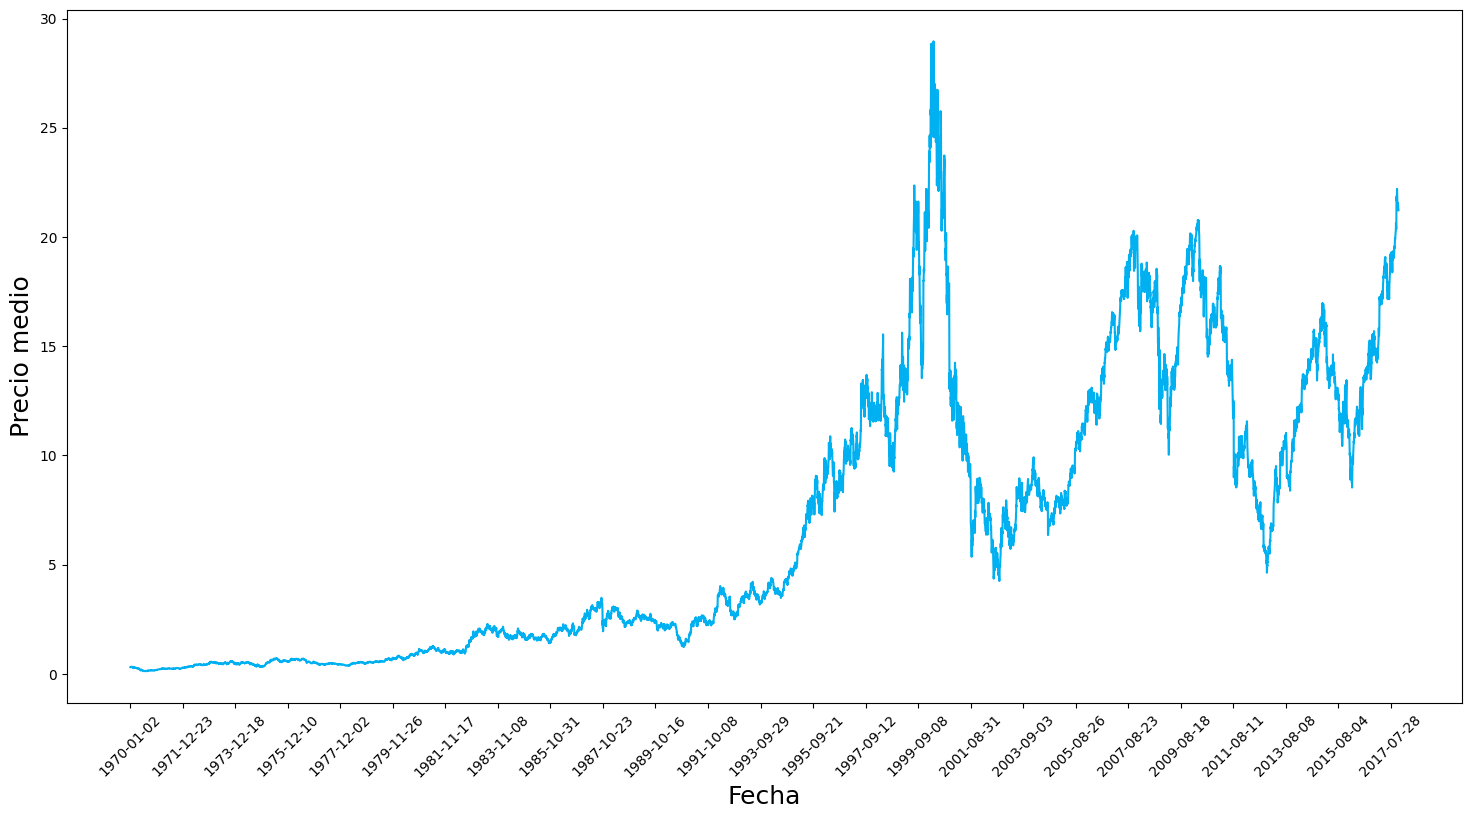

In [4]:
plt.figure(figsize = (18,9))
plt.plot(range(dataset.shape[0]),(dataset['Low']+dataset['High'])/2.0, color = "#00b0f0")
plt.xticks(range(0,dataset.shape[0],500),dataset['Date'].loc[::500],rotation=45)
plt.xlabel('Fecha',fontsize=18)
plt.ylabel('Precio medio',fontsize=18)
plt.show()

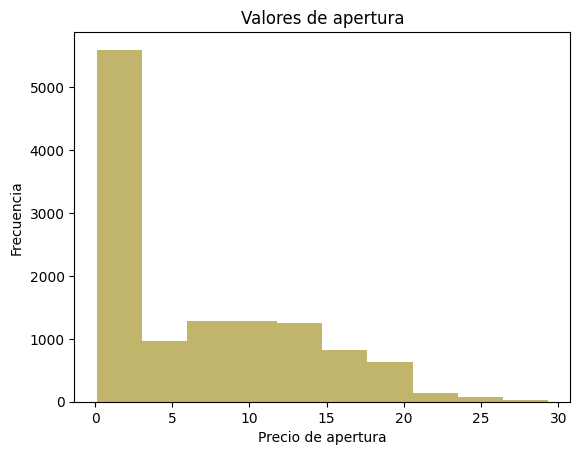

In [5]:
# Histograma de los valores de apertura
plt.hist(dataset['Open'], color='#c1b56b')

# Agregar etiquetas y título al histograma
plt.xlabel('Precio de apertura')
plt.ylabel('Frecuencia')
plt.title('Valores de apertura')

# Mostrar el histograma
plt.show()

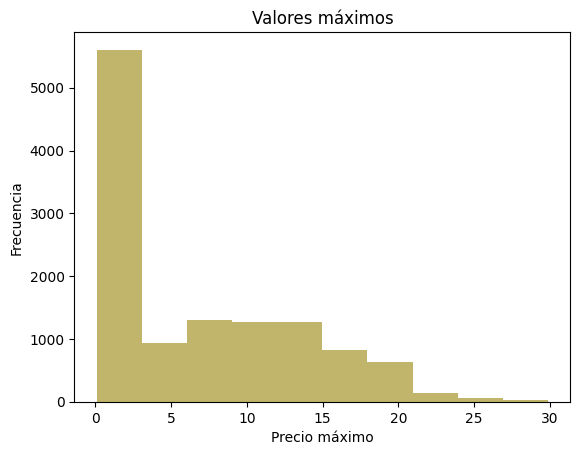

In [6]:
# Histograma de los valores máximos
plt.hist(dataset['High'], color='#c1b56b')

# Agregar etiquetas y título al histograma
plt.xlabel('Precio máximo')
plt.ylabel('Frecuencia')
plt.title('Valores máximos')

# Mostrar el histograma
plt.show()

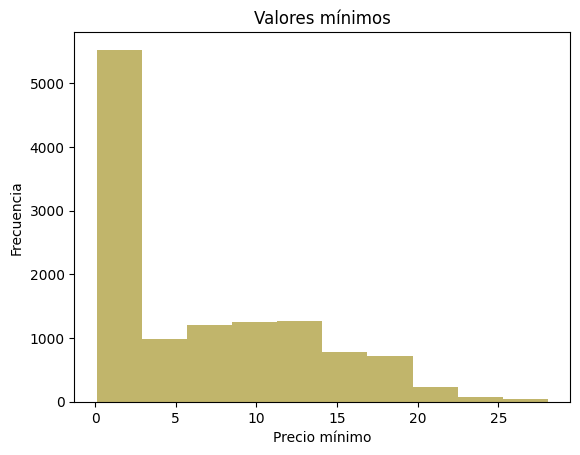

In [7]:
# Histograma de los valores mínimos
plt.hist(dataset['Low'], color='#c1b56b')

# Agregar etiquetas y título al histograma
plt.xlabel('Precio mínimo')
plt.ylabel('Frecuencia')
plt.title('Valores mínimos')

# Mostrar el histograma
plt.show()

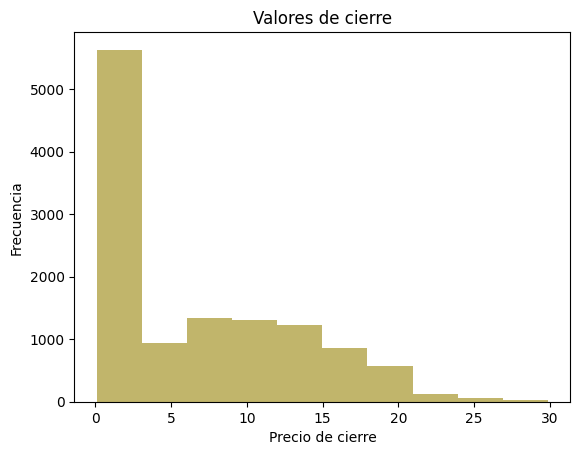

In [8]:
# Histograma de cierre
plt.hist(dataset['Close'], color='#c1b56b')

# Agregar etiquetas y título al histograma
plt.xlabel('Precio de cierre')
plt.ylabel('Frecuencia')
plt.title('Valores de cierre')

# Mostrar el histograma
plt.show()

<ipython-input-9-999991cc0278>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = dataset.corr()


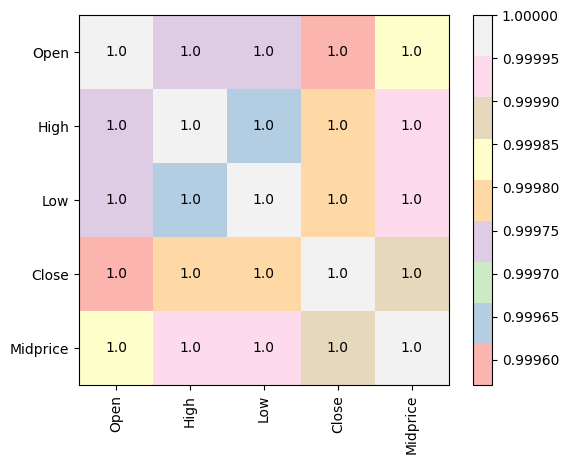

In [9]:
#Mapa de correlación
corr = dataset.corr()

# Crear un mapa de correlación usando la función imshow() de Matplotlib
plt.imshow(corr, cmap='Pastel1')

# Agregar una barra de color
plt.colorbar()

#Definir los nombres de los ejes x y y
tick_labels = [column for column in corr.columns]
plt.xticks(range(len(tick_labels)), tick_labels, rotation=90)
plt.yticks(range(len(tick_labels)), tick_labels)

# Agregar etiquetas a los recuadros
for i in range(len(tick_labels)):
    for j in range(len(tick_labels)):
        plt.text(i, j, round(corr.iloc[i,j],2), ha='center', va='center', color='k')

# Mostrar el mapa
plt.show()

In [10]:
# Obtiene los valores máximo y mínimo de cada columna
max_values = dataset.max()
min_values = dataset.min()

# Crea una nueva tabla con los valores máximo y mínimo de cada columna
summary_table = pd.DataFrame({'max': max_values, 'min': min_values})

# Muestra la tabla
print(summary_table)

                 max         min
Date      2017-11-10  1970-01-02
Open          29.328     0.11867
High          29.857     0.11867
Low           28.062     0.11482
Close         29.857     0.11482
Midprice     28.9595    0.116745


## 5.6 Creación de un conjunto de entrenamiento

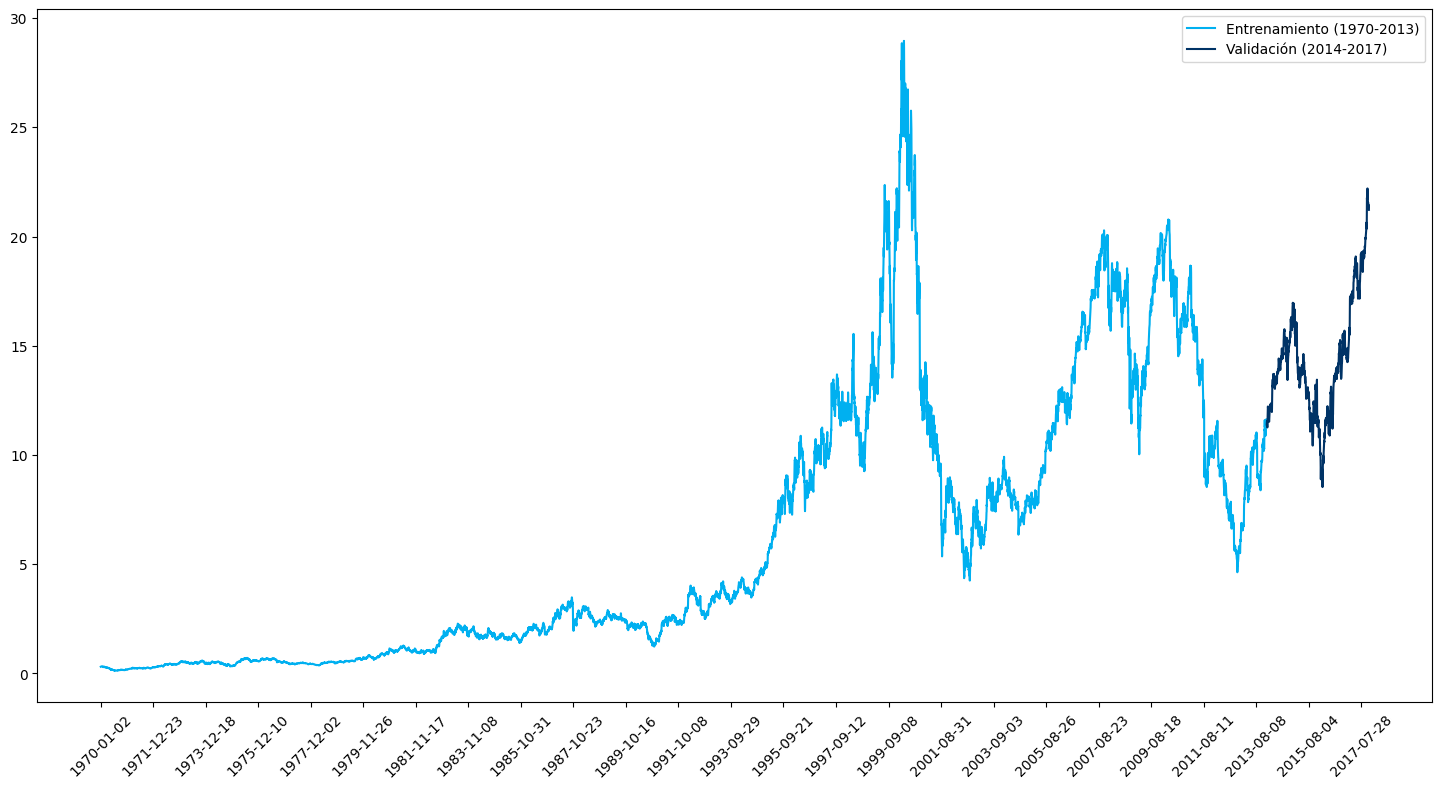

In [11]:
# Sets de entrenamiento y validación 
# La LSTM se entrenará con datos del 2013 hacia atrás. La validación se hará con datos del 2014 en adelante.
# En ambos casos sólo se usará el precio medio de la acción para cada día

set_entrenamiento = dataset[:11101].iloc[:,5:6]
set_validacion = dataset[11101:].iloc[:,5:6]

plt.figure(figsize=(18,9))
set_entrenamiento['Midprice'].plot(legend=True, color = "#00b0f0")
set_validacion['Midprice'].plot(legend=True, color = "#003366")
plt.legend(['Entrenamiento (1970-2013)', 'Validación (2014-2017)'])
plt.xticks(range(0,dataset.shape[0],500),dataset['Date'].loc[::500],rotation=45)
plt.show()

## 5.4 Escalado de atributos

In [12]:
# Normalización del set de entrenamiento
sc = MinMaxScaler(feature_range=(0,1))
set_entrenamiento_escalado = sc.fit_transform(set_entrenamiento)

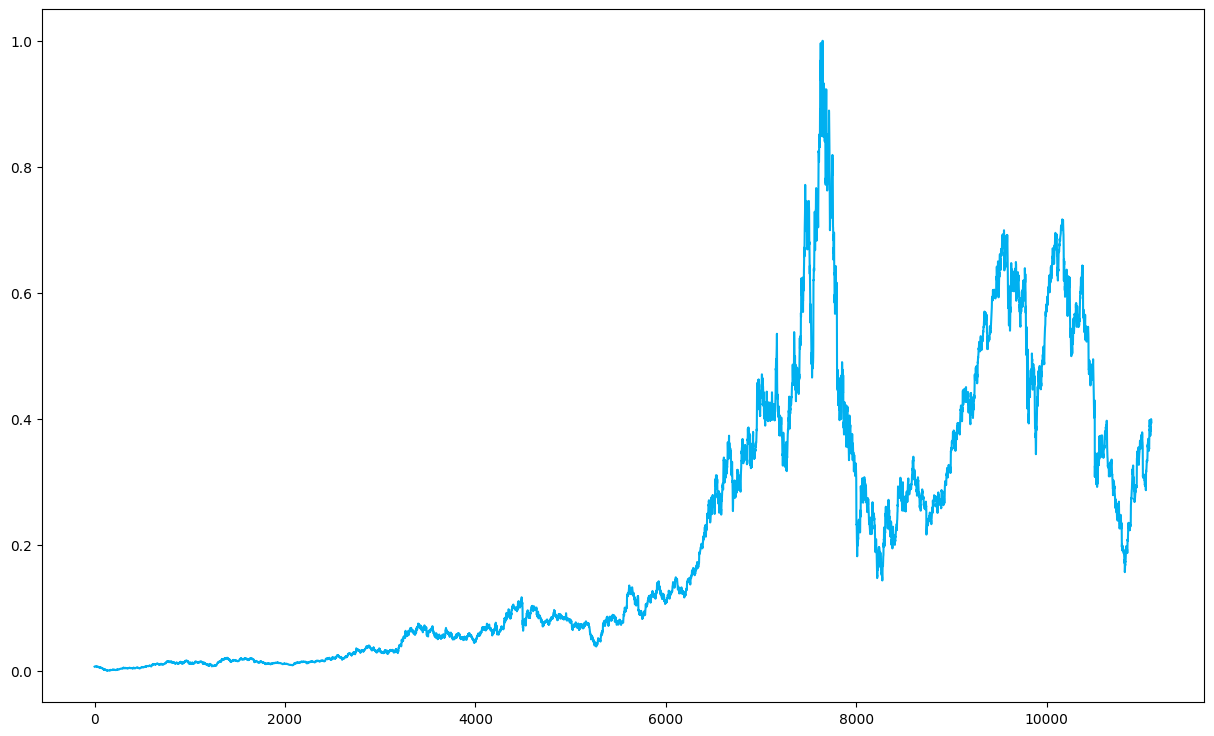

In [25]:
plt.figure(figsize=(15, 9))
plt.plot(set_entrenamiento_escalado, color = '#00b0f0')

## Entrenamiento y validación

In [13]:
# Función graficar

def graficar_predicciones(real, prediccion):
    plt.plot(real[0:len(prediccion)],color='#4baf73', label='Valor real de la acción')
    plt.plot(prediccion, color='#a31515', label='Predicción de la acción')
    plt.ylim(1.1 * np.min(prediccion)/2, 1.1 * np.max(prediccion))
    plt.xlabel('Tiempo')
    plt.ylabel('Valor de la acción')
    plt.legend()
    plt.show()

In [20]:
# La red LSTM tendrá como entrada "time_step" datos consecutivos, y como salida 1 dato (la predicción a
# partir de esos "time_step" datos).
time_step = 60
X_train = []
Y_train = []
m = len(set_entrenamiento_escalado)

for i in range(time_step,m):
    # X: bloques de "time_step" datos: 0-time_step, 1-time_step+1, 2-time_step+2, etc
    X_train.append(set_entrenamiento_escalado[i-time_step:i,0])

    # Y: el siguiente dato
    Y_train.append(set_entrenamiento_escalado[i,0])
X_train, Y_train = np.array(X_train), np.array(Y_train)

# Reshape X_train para que se ajuste al modelo en Keras
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))


# Red LSTM
dim_entrada = (X_train.shape[1],1)
dim_salida = 1
na = 50

In [26]:
dim_entrada

(60, 1)

In [ ]:
modelo = Sequential()
modelo.add(LSTM(units=na, input_shape=dim_entrada))
modelo.add(Dense(units=dim_salida))
modelo.compile(optimizer='rmsprop', loss='mse')
modelo.fit(X_train,Y_train,epochs=10,batch_size=20)


# Validación (predicción del valor de las acciones)
x_test = set_validacion.values
x_test = sc.transform(x_test)

X_test = []
for i in range(time_step,len(x_test)):
    X_test.append(x_test[i-time_step:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

prediccion = modelo.predict(X_test)
prediccion = sc.inverse_transform(prediccion)

# Graficar resultados
graficar_predicciones(set_validacion.values, prediccion)

In [ ]:
# Función graficar

def graficar_predicciones_desplazado(real, prediccion):
    plt.plot(real[60:],color='#4baf73', label='Valor real de la acción')
    plt.plot(prediccion, color='#a31515', label='Predicción de la acción')
    plt.ylim(1.1 * np.min(prediccion)/2, 1.1 * np.max(prediccion))
    plt.xlabel('Tiempo')
    plt.ylabel('Valor de la acción')
    plt.legend()
    plt.show()

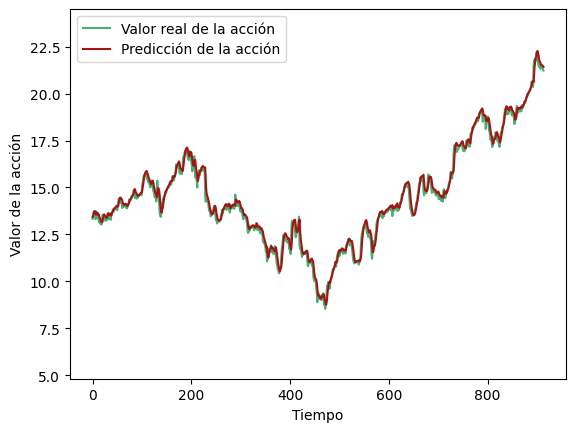

In [ ]:
graficar_predicciones_desplazado(set_validacion.values, prediccion)

In [ ]:
mse = mean_squared_error(set_validacion.values[60:], prediccion)
mse

0.07953473573511485

In [ ]:
from sklearn.metrics import r2_score
r2 = r2_score(set_validacion.values[60:], prediccion)
r2

0.9890953570058153